In [108]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Layer
from keras.layers import Input, Dense, Activation, LeakyReLU, Permute, Bidirectional, CuDNNLSTM
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
import tensorflow as tf
import tensorflow as tf
from primus import CTC_PriMuS
import ctc_utils
import os
import tensorflow as tf
from primus import CTC_PriMuS
import ctc_utils
import os
import cv2
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [109]:
tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [110]:
def default_model_params(img_height, vocabulary_size):
    params = dict()
    params['img_height'] = img_height
    params['img_width'] = None
    params['batch_size'] = 128
    params['img_channels'] = 1
    params['conv_blocks'] = 4
    params['conv_filter_n'] = [32, 64, 128, 256]
    params['conv_filter_size'] = [ [3,3], [3,3], [3,3], [3,3] ]
    params['conv_pooling_size'] = [ [2,2], [2,2], [2,2], [2,2] ]
    params['rnn_units'] = 128
    params['rnn_layers'] = 2
    params['vocabulary_size'] = vocabulary_size
    return params

In [111]:
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost
        # self.loss_fn = K.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64") # 16
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        print("Y_pred shape:  ",y_pred.shape)
        print("Y_true shape:  ",y_true.shape)
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [112]:

def ctc_crnn(params,width_rem = 128):
    input_shape = (params['img_height'],params['img_width'], params['img_channels'])

    inputs = Input(name='image', shape=input_shape, dtype='float32')

    labels = Input(name="label", shape=(None,), dtype="float32")

    width_reduction = 1
    height_reduction = 1

    #conv2d layer
    for i in range(params['conv_blocks']):
            inner = Conv2D(params['conv_filter_n'][i], params['conv_filter_size'][i], padding='same', name='conv'+ str(i+1), kernel_initializer='he_normal')(inputs if i == 0 else inner)
            inner = BatchNormalization()(inner)
            inner = LeakyReLU(0.2)(inner)
            inner = MaxPooling2D(pool_size=params['conv_pooling_size'][i], strides = params['conv_pooling_size'][i], name='max' + str(i+1))(inner)

            width_reduction = width_reduction * params['conv_pooling_size'][i][1]
            height_reduction = height_reduction * params['conv_pooling_size'][i][0]
            print(width_reduction)
    
    print(width_reduction)
    features = K.permute_dimensions(inner, (2,0,3,1))
    feature_dim = params['conv_filter_n'][-1] * (params['img_height'] / height_reduction)
    feature_width = width_rem / width_reduction
    print("Feature width:",feature_width)
    features = tf.reshape(features, tf.stack([tf.cast(feature_width,'int32'), 16, tf.cast(feature_dim,'int32')]))
    
    # RNN block
    lstm_1 = CuDNNLSTM(params['rnn_units'], return_sequences=True, kernel_initializer='he_normal', name='lstm1')(features)  # (None, 32, 512)
    lstm_1b = CuDNNLSTM(params['rnn_units'], return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(features)
    reversed_lstm_1b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)

    lstm1_merged = add([lstm_1, reversed_lstm_1b])  # (None, 32, 512)
    lstm1_merged = BatchNormalization()(lstm1_merged)
    
    lstm_2 = CuDNNLSTM(params['rnn_units'], return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = CuDNNLSTM(params['rnn_units'], return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    reversed_lstm_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_2b)

    lstm2_merged = concatenate([lstm_2, reversed_lstm_2b])  # (None, 32, 1024)
    lstm2_merged = BatchNormalization()(lstm2_merged)

    # transforms RNN output to character activations:
    num_classes = params['vocabulary_size'] + 1
    inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(lstm2_merged) #(None, 32, 63)
    y_pred = Activation('softmax', name='softmax')(inner)

    output = CTCLayer(name="ctc_loss")(labels, y_pred)


    return Model(inputs=[inputs, labels], outputs=output)

In [113]:
corpus_dirpath = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/primusCalvoRizoAppliedSciences2018/"
corpus_filepath = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/train.txt"
dictionary_path = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/vocabulary_semantic.txt"
primus = CTC_PriMuS(corpus_dirpath,corpus_filepath,dictionary_path, True, val_split = 0.1)

Training with 9000 and validating with 1000


In [114]:
# Get Data
image_paths = []
image_texts = []

class PriMuS_Data:
    def __init__(self, corpus_dirpath, corpus_filepath, dictionary_path):
        self.corpus_dirpath = corpus_dirpath

        # Corpus
        corpus_file = open(corpus_filepath,'r')
        self.corpus_list = corpus_file.read().splitlines()
        corpus_file.close()

        self.current_idx = 0

        # Dictionary
        self.word2int = {}
        self.int2word = {}
            
        dict_file = open(dictionary_path,'r')
        dict_list = dict_file.read().splitlines()
        for word in dict_list:
            if not word in self.word2int:
                word_idx = len(self.word2int)
                self.word2int[word] = word_idx
                self.int2word[word_idx] = word

        dict_file.close()

        self.vocabulary_size = len(self.word2int)
    
    def get_vocabulary_size(self):
        return self.vocabulary_size
        
    def get_data(self):
        return self.corpus_list

    def encode_seqs(self, seqs):
        encoded = []
        for seq in seqs:
            new_seq=[]
            for sym in seq:
                new_seq.append(self.word2int[sym])
            encoded.append(new_seq)
        return encoded

    def trim_ds(self):
        val_split = 0.9
        folder_path = self.corpus_dirpath
        list_of_files = self.corpus_list #10,000 filenames

        image_paths = [self.corpus_dirpath+f"{x}/{x}.png" for x in self.corpus_list] # list of image paths
        text_paths = [self.corpus_dirpath+f"{x}/{x}.semantic" for x in self.corpus_list]

        image_texts = [] # list of strings

        for path in text_paths:
            with open(path, "r") as file:
                image_texts.append(file.readline().split())

        image_texts = self.encode_seqs(image_texts)

        max_label_len = max([len(seq) for seq in image_texts])
        padded_image_texts = pad_sequences(image_texts, maxlen=max_label_len, padding='post', value= self.vocabulary_size + 1)

        # TODO: do line 17 from the link : https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

        # TODO: Use self.word2int to encode each element of the lists in image_texts
        # Input image_texts = [  ['clef','C-note'] , [.......], ....]
        # Final image_texts = [  [5,3] , [.......], ....]
        # if 'clef' == 5, 'C-note' == 3 in word2int dictionary
        # Also add padding using the function below so length of each element is consistent

        # from tensorflow.keras.preprocessing.sequence import pad_sequences
        # padded_image_texts = list(map(encode_to_labels, image_texts))
        # padded_image_texts[0]


        train_image_paths = image_paths[ : int(len(image_paths) * val_split)]
        train_image_texts = padded_image_texts[ : int(len(padded_image_texts) * val_split)]

        val_image_paths = image_paths[int(len(image_paths) * val_split) : ]
        val_image_texts = padded_image_texts[int(len(padded_image_texts) * val_split) : ]

        return {"train":{"images":train_image_paths, "text": train_image_texts}, "val":{"images":val_image_paths, "text": val_image_texts}}



In [115]:
data_obj = PriMuS_Data(corpus_dirpath, corpus_filepath, dictionary_path)
lst = data_obj.trim_ds()

In [116]:
# TODO: do line 17 from the link : https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

In [117]:
print(data_obj.vocabulary_size)

1781


In [118]:
# Resize images to desired dimensions with unknown width
def resize_no_width(image, height):
    width = int(float(height * image.shape[1]) / image.shape[0])
    sample_img = cv2.resize(image, (width, height))
    return sample_img


# Pre-process a single image sample(resize/normalize/max_width resize)
def process_single_sample(img_path, label,max_width = 30):
    params = default_model_params(img_height,primus.vocabulary_size)
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img,[params['img_height'], max_width])
    # TODO: Get height from params, calculate width from max of all images
    return {"image": img, "label": label}


In [120]:
batch_size = 32


image_widths = [cv2.imread(img).shape[1] for img in lst["train"]["images"]]
max_image_width = max(image_widths)
print(max_image_width)
# Parameterization
img_height = 128
params = default_model_params(img_height,primus.vocabulary_size)
max_epochs = 100
dropout = 0.5
# Model
model = ctc_crnn(params, width_rem= max_image_width)
# model.summary()

# Pre-process a single image sample(resize/normalize/max_width resize)
def process_single_sample(img_path, label):
    params = default_model_params(img_height,primus.vocabulary_size)
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img,[params['img_height'], max_image_width])
    # TODO: Get height from params, calculate width from max of all images
    return {"image": img, "label": label}
# train_dataset = train_dataset.map(process_single_sample(max_width = max_image_width))

# processed_images = [process_single_sample(img,label,max_image_width) for img,label in zip(lst["train"]["images"], lst["train"]["text"])]

train_dataset = tf.data.Dataset.from_tensor_slices((lst['train']['images'], lst['train']['text']))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((lst['train']['images'], lst['train']['text']))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

2003
2
4
8
16
16
Feature width: 125.1875
Y_pred shape:   (125, 16, 1782)
Y_true shape:   (None, None)


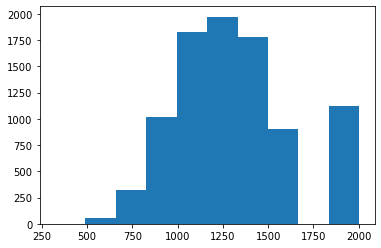

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.Series(image_widths)
plt.hist(df)
plt.show()

https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

In [122]:
# Compile

optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(optimizer = optimizer)

# checkpoint = ModelCheckpoint(filepath=file_path, 
#                                 monitor='val_loss', 
#                                 verbose=1, 
#                                 save_best_only=True, 
#                                 mode='min')

#     callbacks_list = [checkpoint, 
#                       WandbCallback(monitor="val_loss", 
#                                     mode="min", 
#                                     log_weights=True),
#                       PlotPredictions(frequency=1),
#                       EarlyStopping(patience=3, verbose=1)]

history = model.fit(train_dataset, 
                    epochs = max_epochs,
                    validation_data=validation_dataset,
                    verbose = 1,
                    # callbacks = callbacks_list,
                    shuffle=True)

c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
Y_pred shape:   (125, 16, 1782)
Y_true shape:   (None, 56)
Y_pred shape:   (125, 16, 1782)
Y_true shape:   (None, 56)


ResourceExhaustedError: Graph execution error:

Detected at node 'model/leaky_re_lu/LeakyRelu' defined at (most recent call last):
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\steli\AppData\Local\Temp\ipykernel_2596\825552303.py", line 19, in <cell line: 19>
      history = model.fit(train_dataset,
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\layers\advanced_activations.py", line 77, in call
      return backend.relu(inputs, alpha=self.alpha)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\backend.py", line 4939, in relu
      return tf.nn.leaky_relu(x, alpha=alpha)
Node: 'model/leaky_re_lu/LeakyRelu'
Detected at node 'model/leaky_re_lu/LeakyRelu' defined at (most recent call last):
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\steli\AppData\Local\Temp\ipykernel_2596\825552303.py", line 19, in <cell line: 19>
      history = model.fit(train_dataset,
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\layers\advanced_activations.py", line 77, in call
      return backend.relu(inputs, alpha=self.alpha)
    File "c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\backend.py", line 4939, in relu
      return tf.nn.leaky_relu(x, alpha=alpha)
Node: 'model/leaky_re_lu/LeakyRelu'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,32,128,2003] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/leaky_re_lu/LeakyRelu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[model/ctc_loss/Log/_58]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,32,128,2003] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/leaky_re_lu/LeakyRelu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7260]